# Deep Learning with PyTorch : Build an AutoEncoder

An autoencoder is a type of neural network that learns to copy its input to its output. In autoencoder, encoder encodes the image into compressed representation, and the decoder decodes the representation.

![](denoising_autoencoder.png)

Applications of AutoEncoder:

- Segmentation
- Denoising Image
- Super Resolution Image
- Image Compression
- and many more .....

In this Project, you will see the simplest implemention of autoencoder for image denoising task.

In [2]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

# Exploring Dataset 

In [4]:
data = pd.read_csv('mnist_dataset.csv')
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
image = data.iloc[18] #selecting image at index 3
image = np.array(image).astype('float32')
#(784,) -> (28x28)
image = np.reshape(image,(28,28)) #reshaping
image = image / 255 #normalize 0 -1

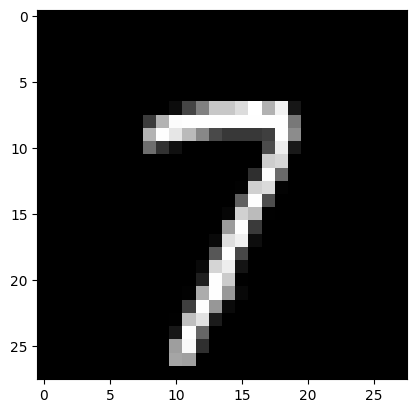

In [8]:
plt.imshow(image, cmap='gray')

In [9]:
noisy_image = image + 0.2 * np.random.randn(*image.shape)
noisy_image = np.clip(noisy_image,0,1)

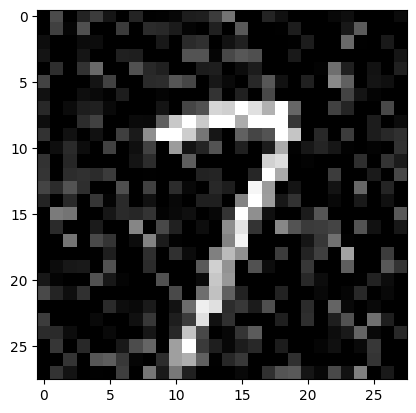

In [10]:
plt.imshow(noisy_image, cmap="gray")

# Data Preparation 

In [11]:
from torch.utils.data import Dataset
from helper import show_image, ToTensorForAE

<img src="dataset.png" alt="drawing" width="400"/>

In [14]:
class MNIST_AE_Dataset(Dataset):
    def __init__(self, csv_file, noise_factor=0.2, transform=None):
        self.data = pd.read_csv(csv_file)
        self.noise_factor = noise_factor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data.iloc[idx]
        img = np.array(img)
        img = np.reshape(img,(28,28,1))/255

        noisy_img = img + self.noise_factor* np.random.randn(*img.shape)
        noisy_img = np.clip(noisy_img,0,1)

        sample = (noisy_img,img)
        if self.transform:
            sample = self.transform(sample)

        return sample



### **Here to ToTensorForAE() is a custom transform which will convert numpy,PIL image to torch tensor and also it will convert image with (height,width,channel) to (channel,height,width) as per the pytorch model input convention.**

For eg, numpy array image with shape (28,28,1) will be first converted to image torch tensor with shape(28,28,1)
and then the channel is shifted to 0th axis so image tensor will be with shape (1,28,28)

In [15]:
trainset = MNIST_AE_Dataset('mnist_dataset.csv', transform = ToTensorForAE())

In [16]:
print("Size of trainset : {}".format(len(trainset)))

Size of trainset : 42000


In [19]:
noisy_img,org_img = trainset[32]

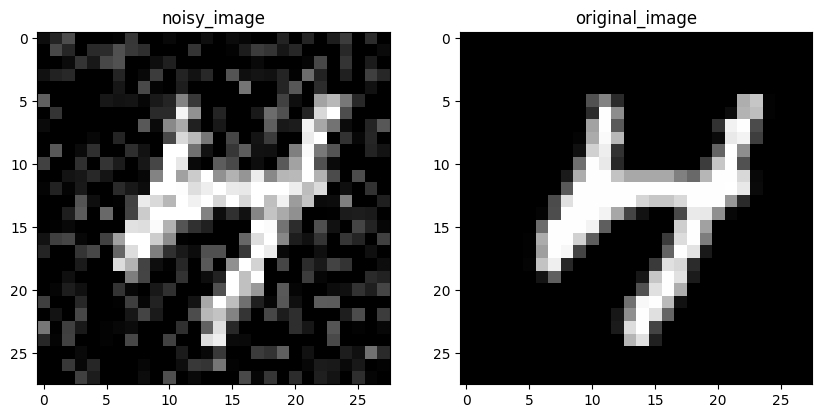

In [20]:
show_image(noisy_img,org_img)

# Load dataset into batches

In [21]:
from torch.utils.data import DataLoader

In [23]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)

In [25]:
dataiter = iter(trainloader)
noisy_img,org_img = next(dataiter)

print("Shape of loading one batch : {}".format(noisy_img.shape))

print("Total no. of batches: {}".format(len(trainloader))) #total number of batches
print("Total no. of examples : {}".format(len(trainloader.dataset)))

Shape of loading one batch : torch.Size([16, 1, 28, 28])
Total no. of batches: 2625
Total no. of examples : 42000


# Create AutoEncoder Model

In [27]:
from torch import nn
from torchsummary import summary

In [35]:
def Encoder():
    enc = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = (3,3), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2)),
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2))
    )
    return enc

In [36]:
def Decoder():
    dec = nn.Sequential(
        nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = (2,2), stride = 2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels = 16, out_channels = 1, kernel_size = (2,2), stride = 2),
        nn.Sigmoid()
    )
    return dec

In [37]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self,inp_imgs):
        encoder_out = self.encoder(inp_imgs)
        decoder_out = self.decoder(encoder_out)
        return decoder_out

model = AutoEncoder()
model

        

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [38]:
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]           2,064
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.03
Estimated Total

# Train AutoEncoder Model 

In [39]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.MSELoss()
epochs = 10

In [40]:
for i in range(epochs):
    train_loss = 0.0
    model.train()
    for batch in tqdm(trainloader):
        noisy_img,org_img = batch
        
        denoised_img = model(noisy_img)
        loss = criterion(denoised_img, org_img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    avg_train_loss = train_loss/len(trainloader)
    print("Epoch : {} Train Loss: {}".format(i+1, avg_train_loss))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2625/2625 [00:19<00:00, 136.73it/s]


Epoch : 1 Train Loss: 0.015471200981665226


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2625/2625 [00:18<00:00, 138.27it/s]


Epoch : 2 Train Loss: 0.005886273679988725


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2625/2625 [00:19<00:00, 134.45it/s]


Epoch : 3 Train Loss: 0.005338790000460687


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2625/2625 [00:19<00:00, 131.82it/s]


Epoch : 4 Train Loss: 0.00507940939042185


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2625/2625 [00:19<00:00, 136.66it/s]


Epoch : 5 Train Loss: 0.00492013306374706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2625/2625 [00:19<00:00, 136.84it/s]


Epoch : 6 Train Loss: 0.004806647503216352


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2625/2625 [00:19<00:00, 136.49it/s]


Epoch : 7 Train Loss: 0.004725655506054561


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2625/2625 [00:19<00:00, 134.84it/s]


Epoch : 8 Train Loss: 0.004663723445541802


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2625/2625 [00:19<00:00, 135.85it/s]


Epoch : 9 Train Loss: 0.004610352537905177


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2625/2625 [00:19<00:00, 135.16it/s]

Epoch : 10 Train Loss: 0.004571224658084767


# Plot Results

torch.Size([1, 28, 28])


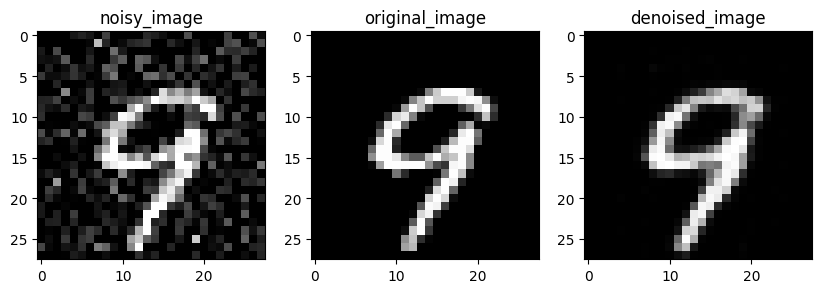

In [46]:
model.eval()
with torch.no_grad():
    dataiter = iter(trainloader)
    sample = next(dataiter)

    noisy_img,org_img = sample

    index = 15

    denoised_img = model(noisy_img[index].unsqueeze(0)) #(c,h,w) -> (bs,c,h,w)
    print(denoised_img.squeeze(0).shape)

    show_image(noisy_img[index], org_img[index], denoised_img.squeeze(0))